In [ ]:
from nbdev import *
%nbdev_default_export architectures

Cells will be exported to pct.architectures,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Architectures

> Classes to create hierachy architectures from array configurations.

In [ ]:
%nbdev_hide
import sys
sys.path.append("..")

In [ ]:
%nbdev_export
import random
import numpy as np
import json
import os
import enum
import socket
from jproperties import Properties
from abc import ABC, abstractmethod

from pct.hierarchy import PCTHierarchy
from pct.nodes import PCTNode
from pct.functions import ControlUnitFunctions
from pct.functions import WeightedSum
from pct.functions import IndexedParameter
from pct.functions import Constant
from pct.environments import PendulumV0
from pct.environments import VelocityModel
from pct.environments import EnvironmentFactory
from pct.structure import ArchitectureStructure
from pct.structure import LevelKey
from pct.errors import BaseErrorCollector
from pct.putils import stringListToListOfStrings

In [ ]:
%nbdev_export
class BaseArchitecture(ABC):
    "Base class of an array architecture. This class is not used direclty by developers, but defines the functionality common to all."
    def __init__(self, name, config, env, inputs, history, error_collector):
        self.config = config      
        self.env = env
        self.inputs=inputs
        self.hpct = PCTHierarchy(history=history, error_collector=error_collector)
        self.hpct.add_preprocessor(env)
        
        for input in inputs:
            self.hpct.add_preprocessor(input)
        
    def __call__(self):
        #level0config = self.config['level0']
        previous_columns=self.configure_zerothlevel()
        
        intermediate_levels = len(self.config)-3
        level=-1
        for level in range(intermediate_levels):
            leveln = self.config[f'level{level+1}']
            levelcolumns = self.configure_level(leveln, previous_columns, level+1)
            previous_columns=levelcolumns
        if intermediate_levels < 0:
            self.set_references()          
        else:
            level+=1
            self.configure_top_level(self.config[f'level{level+1}'], level+1)
            
    def get_hierarchy(self):
        return self.hpct

    @classmethod
    def from_raw(cls, raw):
        config = {}
        config['parameters']={}
        for level in range(len(raw)):
            config[f'level{level}'] = raw[level]
        return config

 

In [ ]:
%nbdev_export
class ProportionalArchitecture(BaseArchitecture):
    "Proportional Architecture"
    def __init__(self, name="proportional", config=None, env=None, input_indexes=None, history=False, error_collector=None, **cargs):
        inputs=[]
        for ctr in range(len(input_indexes)):
            ip = IndexedParameter(index=input_indexes[ctr], name=f'Input{ctr}', links=[env])
            inputs.append(ip)
        
        super().__init__(name, config, env, inputs, history, error_collector)

    def configure_zerothlevel(self):
        inputsIndex=0
        outputsIndex=1
        actionsIndex=2

        config=self.config['level0']
        level=0
        numInputs= len(self.inputs)
        columns = len(config[inputsIndex][0])
        #print(config[0][0])
        #print(columns)

        # create nodes
        for column in range(columns):
            node = PCTNode(build_links=True, mode=1, name=f'L{level}C{column}', history=self.hpct.history)
            # change names
            node.get_function("perception").set_name(f'PL{level}C{column}ws')
            node.get_function("reference").set_name(f'RL{level}C{column}ws')
            node.get_function("comparator").set_name(f'CL{level}C{column}')
            node.get_function("output").set_name(f'OL{level}C{column}p')

            weights=[]
            # configure perceptions
            for inputIndex in range(numInputs):
                node.get_function("perception").add_link(self.inputs[inputIndex])
                weights.append(config[inputsIndex][inputIndex][column])
            node.get_function("perception").weights=np.array(weights)

            # configure outputs
            node.get_function("output").set_property('gain', config[outputsIndex][column])

            self.hpct.add_node(node, level, column)

        # configure actions
        numActions = len(config[actionsIndex])
        numColumnsThisLevel = len(config[outputsIndex])
        for actionIndex in range(numActions):
            action = WeightedSum(weights=config[actionsIndex][actionIndex], name=f'Action{actionIndex+1}ws')
            for column in range(numColumnsThisLevel):
                action.add_link(f'OL{level}C{column}p')
            self.hpct.add_postprocessor(action)
            self.env.add_link(action)

        return numColumnsThisLevel

    def configure_level(self, config, numColumnsPreviousLevel, level):
        inputsIndex=0
        outputsIndex=1
        referencesIndex=2
        
        #numColumnsPreviousLevel=len(config[referencesIndex])
        numColumnsThisLevel = len(config[outputsIndex])
    
        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=1, name=f'L{level}C{column}', history=self.hpct.history)
            # change names
            node.get_function("perception").set_name(f'PL{level}C{column}ws')
            node.get_function("reference").set_name(f'RL{level}C{column}ws')
            node.get_function("comparator").set_name(f'CL{level}C{column}')
            node.get_function("output").set_name(f'OL{level}C{column}p')
            
            weights=[]
            # configure perceptions        
            for inputIndex in range(numColumnsPreviousLevel):
                node.get_function("perception").add_link(f'PL{level-1}C{inputIndex}ws')
                weights.append(config[inputsIndex][column][inputIndex])           
    
            node.get_function("perception").weights=np.array(weights)
            
            # configure outputs
            node.get_function("output").set_property('gain', config[outputsIndex][column])        
                
            self.hpct.add_node(node, level, column)
    
        # configure lower references
        for referenceIndex in range(numColumnsPreviousLevel):
            reference = self.hpct.get_function(level-1, referenceIndex, "reference")
            weights=[]
            
            for output_column in range(numColumnsThisLevel):
                reference.add_link(f'OL{level}C{output_column}p')
                weights.append(config[referencesIndex][referenceIndex][output_column])           
                
            reference.weights=np.array(weights)
    
        return numColumnsThisLevel

    def configure_top_level(self, config, level):
        inputsIndex=0
        outputsIndex=1
        lowerReferencesIndex=2
        topReferencesIndex=3
    
        numColumnsThisLevel = len(config[topReferencesIndex])
        numColumnsPreviousLevel=len(config[lowerReferencesIndex])
        
        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=2, name=f'L{level}C{column}', history=self.hpct.history)
            # change names
            reference = Constant(config[topReferencesIndex][column], name=f'RL{level}C{column}c')
            node.replace_function("reference", reference, 0)
            node.get_function("perception").set_name(f'PL{level}C{column}ws')
            #node.get_function("reference").set_name(f'RL{level}C{column}ws')
            node.get_function("comparator").set_name(f'CL{level}C{column}')
            node.get_function("output").set_name(f'OL{level}C{column}p')
            node.get_function("comparator").set_link(reference)
            node.get_function("comparator").add_link(node.get_function("perception"))
            
            # set reference value
            #node.get_function("reference").set_property('value', config[topReferencesIndex][column])
            
            
            weights=[]
            # configure perceptions        
            for inputIndex in range(numColumnsPreviousLevel):
                node.get_function("perception").add_link(f'PL{level-1}C{inputIndex}ws')
                weights.append(config[inputsIndex][column][inputIndex])           
                #weights.append(config[inputsIndex][inputIndex][column])           
            node.get_function("perception").weights=np.array(weights)
            
            # configure outputs
            node.get_function("output").set_property('gain', config[outputsIndex][column])        
                
            self.hpct.add_node(node, level, column)
    
        # configure lower references
        for referenceIndex in range(numColumnsPreviousLevel):
            reference = self.hpct.get_function(level-1, referenceIndex, "reference")
            weights=[]
            
            for output_column in range(numColumnsThisLevel):
                reference.add_link(f'OL{level}C{output_column}p')
                weights.append(config[lowerReferencesIndex][referenceIndex][output_column])           
                
            reference.weights=np.array(weights)


    def set_references(self):
        level=0
        config=self.config['level0']
        topReferencesIndex=3
    
        numColumnsThisLevel = len(config[topReferencesIndex])
        # change nodes
        for column in range(numColumnsThisLevel):
            node = self.hpct.get_node(level, column)
            reference = Constant(config[topReferencesIndex][column], name=f'RL{level}C{column}c')
            node.replace_function("reference", reference, 0)
            node.get_function("comparator").set_link(reference)
            node.get_function("comparator").add_link(node.get_function("perception"))


 


In [ ]:
#export
class DynamicArchitecture(BaseArchitecture):
    "Dynamic Architecture"
    def __init__(self, name="dynamic", structure=None, config=None, env=None, input_indexes=None, 
                 top_input_indexes=None, history=False, error_collector=None, suffixes = False, **cargs):
        inputs=[]
        if top_input_indexes != None:
            self.top_inputs = []
        else:
            self.top_inputs = None

        for ctr in range(len(input_indexes)):
            ip = IndexedParameter(index=input_indexes[ctr], name=f'Input{ctr}', links=[env])
            inputs.append(ip)
            if top_input_indexes != None:
                if input_indexes[ctr] in top_input_indexes :
                    self.top_inputs.append(ip)
            
        super().__init__(name, config, env, inputs, history, error_collector)
        self.suffixes=suffixes
        self.structure=structure

    def __call__(self):
        #level0config = self.config['level0']
        levels = len(self.config)-1
        #print('levels', levels)
        if levels == 1:
            self.configure_zerotoplevel()
        else:           
            previous_columns=self.configure_zerothlevel()
            
            intermediate_levels = len(self.config)-3
            level=-1
            for level in range(intermediate_levels):
                leveln = self.config[f'level{level+1}']
                levelcolumns = self.configure_level(leveln, previous_columns, level+1)
                previous_columns=levelcolumns
            if intermediate_levels < 0:
                self.set_references()          
            else:
                level+=1
                self.configure_top_level(self.config[f'level{level+1}'], level+1, previous_columns)
        if self.suffixes:
            self.hpct.set_suffixes()


    def configure_zerotoplevel(self):
        #print(self.structure.get_parameter('modes'))
        mode = self.structure.get_parameter('modes')[LevelKey.ZEROTOP]

        inputsIndex=0
        outputsIndex=1
        referencesIndex=2
        actionsIndex=3

        config=self.config['level0']
        level=0
        #numInputs= len(self.inputs)
        columns = len(config[inputsIndex][0])
        #print(config[0][0])
        #print('columns',columns)

        # create nodes
        for column in range(columns):
            node = PCTNode(build_links=True, mode=mode, name=f'L{level}C{column}', history=self.hpct.history)
            self.structure.set_node_function(node, ControlUnitFunctions.REFERENCE, mode , level, None, None,  column, None, None, config[referencesIndex], True)            
            self.structure.set_node_function(node, ControlUnitFunctions.PERCEPTION, mode, level, None, None,  column, len(self.inputs), self.inputs, config[inputsIndex], False)

            comparator_name=f'CL{level}C{column}'
            node.get_function("comparator").set_name(comparator_name)
            node.get_function("comparator").set_link(node.get_function("reference"))
            node.get_function("comparator").add_link(node.get_function("perception"))

            self.structure.set_output_function(node, mode, level, column, config[outputsIndex])

            self.hpct.add_node(node, level, column)

        # configure actions
        numColumnsThisLevel = len(config[outputsIndex])
        self.structure.set_action_function(self.hpct, self.env, numColumnsThisLevel, config[actionsIndex])
        
        return numColumnsThisLevel
            
    def configure_zerothlevel(self):
        mode = self.structure.get_parameter('modes')[LevelKey.ZERO]

        inputsIndex=0
        outputsIndex=1
        referencesIndex=2
        actionsIndex=3

        config=self.config['level0']
        level=0
        columns = len(config[inputsIndex][0])
        #print(config[0][0])
        #print(columns)
        columnsNextLevel = len(config[referencesIndex][0])
        #print('columnsNextLevel',columnsNextLevel)

        # create nodes
        for column in range(columns):
            node = PCTNode(build_links=True, mode=mode, name=f'L{level}C{column}', history=self.hpct.history)
            self.structure.set_node_function(node, ControlUnitFunctions.REFERENCE, mode, level, level+1, 'O', 
                                             column, columnsNextLevel, None, config[referencesIndex], True)
            self.structure.set_node_function(node, ControlUnitFunctions.PERCEPTION, mode, level, None, None, 
                                             column, len(self.inputs), self.inputs, config[inputsIndex], False)

            comparator_name=f'CL{level}C{column}'
            node.get_function("comparator").set_name(comparator_name)

            self.structure.set_output_function(node, mode, level, column, config[outputsIndex])

            self.hpct.add_node(node, level, column)

        # configure actions
        numColumnsThisLevel = len(config[outputsIndex])
        self.structure.set_action_function(self.hpct, self.env, numColumnsThisLevel, config[actionsIndex])

        return numColumnsThisLevel

    def configure_level(self, config, numColumnsPreviousLevel, level):
        mode = self.structure.get_parameter('modes')[LevelKey.N]

        inputsIndex=0
        outputsIndex=1
        referencesIndex=2

        #numColumnsPreviousLevel=len(config[referencesIndex])
        numColumnsThisLevel = len(config[outputsIndex])
        columnsNextLevel = len(config[referencesIndex][0])
                

        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=mode, name=f'L{level}C{column}', history=self.hpct.history)
            self.structure.set_node_function(node, ControlUnitFunctions.REFERENCE, mode, level, level+1, 'O', 
                                             column, columnsNextLevel, None, config[referencesIndex], True)
            self.structure.set_node_function(node, ControlUnitFunctions.PERCEPTION, mode, level, level-1, 'P', 
                                             column, numColumnsPreviousLevel, None, config[inputsIndex], False)

            comparator_name=f'CL{level}C{column}'
            node.get_function("comparator").set_name(comparator_name)

            self.structure.set_output_function(node, mode, level, column, config[outputsIndex])

            self.hpct.add_node(node, level, column)

        return numColumnsThisLevel

    def configure_top_level(self, config, level, numColumnsPreviousLevel ):
        mode = self.structure.get_parameter('modes')[LevelKey.TOP]
        inputsIndex=0
        outputsIndex=1
        referencesIndex=2

        numColumnsThisLevel = len(config[referencesIndex])

        # create nodes
        for column in range(numColumnsThisLevel):
            node = PCTNode(build_links=True, mode=mode, name=f'L{level}C{column}', history=self.hpct.history)
            
            self.structure.set_node_function(node, ControlUnitFunctions.REFERENCE, mode, level, None, None, 
                                             column, None, None, config[referencesIndex], None)
            
            
            if self.top_inputs != None and column < len(self.top_inputs):            
                self.structure.set_sparse_node_function(node, ControlUnitFunctions.PERCEPTION, level, 
                        self.top_inputs[column], column, config[inputsIndex])
            else:
                self.structure.set_node_function(node, ControlUnitFunctions.PERCEPTION, mode, level, level-1, 'P', 
                                             column, numColumnsPreviousLevel, None, config[inputsIndex], False)

            comparator_name=f'CL{level}C{column}'
            node.get_function("comparator").set_name(comparator_name)
            node.get_function("comparator").set_link(node.get_function('reference'))
            node.get_function("comparator").add_link(node.get_function('perception'))
            
            self.structure.set_output_function(node, mode, level, column, config[outputsIndex])

            self.hpct.add_node(node, level, column)

            
    @classmethod
    def draw_raw(cls, raw, arch_structure=None, env=None, inputs=None, inputs_names=None, move={}, 
                 top_input_indexes=None, figsize=(12,12), layout=None, summary=False):
        if inputs==None:
            num_inputs = len(raw[0][0])
            inputs = [i for i in range(num_inputs)]
            
        if arch_structure==None:
            arch_structure = ArchitectureStructure()
            
        if env == None:
            env = EnvironmentFactory.createEnvironment('DummyModel')
        env.reset()

        config = BaseArchitecture.from_raw( raw)
        #print(config)
        pa = DynamicArchitecture(structure=arch_structure, config=config, env=env, input_indexes=inputs, 
                                 top_input_indexes=top_input_indexes, suffixes=True) 
        pa()
        hpct = pa.get_hierarchy()
        if inputs_names != None:
            for ctr in range(len(inputs_names)):
                hpct.get_preprocessor()[ctr+1].set_name(inputs_names[ctr])
        if summary:
            hpct.summary()
        if layout==None:
            hpct.draw(move=move, figsize=figsize, with_edge_labels=True)
        else:        
            hpct.draw(move=move, figsize=figsize, with_edge_labels=True, layout=layout)

            
    @classmethod        
    def run_raw(cls, raw=None, arch_structure=None, env=None, runs=None, inputs=None, inputs_names=None, 
                history=False, move={}, figsize=(12,12), layout=None, summary=False, draw=False, seed=None, verbose=False,
                error_collector_type ='TotalError', error_response_type ='RootSumSquaredError', error_limit =100, suffixes=False):
        if inputs==None:
            num_inputs = len(raw[0][0])
            inputs = [i for i in range(num_inputs)]       
            
        if arch_structure==None:
            arch_structure = ArchitectureStructure()
                        
        if env == None:
            env = EnvironmentFactory.createEnvironment('DummyModel')
        env.reset()

        config = BaseArchitecture.from_raw( raw)

        error_collector = BaseErrorCollector.collector(error_response_type, error_collector_type, error_limit)
        if seed != None:
            env.set_seed(seed)
        env.reset()

        da = DynamicArchitecture(structure=arch_structure, config=config, env=env, input_indexes=inputs, 
                                 history=history, error_collector=error_collector, suffixes=suffixes) 
        da()
        hpct = da.get_hierarchy()
        if inputs_names != None:
            for ctr in range(len(inputs_names)):
                hpct.get_preprocessor()[ctr+1].set_name(inputs_names[ctr])

        if summary:
            hpct.summary()

        status = hpct.run(steps=runs, verbose=verbose)
        if not status:
            print('Terminated early')

        if draw:
            if layout==None:
                hpct.draw(move=move, figsize=figsize, with_edge_labels=True)
            else:        
                hpct.draw(move=move, figsize=figsize, with_edge_labels=True, layout=layout)

        score = hpct.get_error_collector().error()
        last_step = hpct.last_step()

        return score, last_step, hpct        


In [ ]:
#export
def run_from_properties_file(file_path=None, nevals=None, runs=500, history=True, verbose=None, 
        test=False, move=None, root_dir=None, draw=False, plots_figsize=(15,4), render=True,
        plots=None, seed=None, print_properties=False, figsize=(12,12)):

    if root_dir == None:
        if socket.gethostname() == 'DESKTOP-5O07H5P':
            root_dir='/mnt/c/Users/ruper/Google Drive/'

        if os.name == 'nt' :
            root_dir='C:\\Users\\ruper\\Google Drive\\'
        

    file = ''.join((root_dir, file_path))
    configs = Properties()
    with open(file, 'rb') as config_file:
        configs.load(config_file)
    items_view = configs.items()
    db = {}     
    for item in items_view:
        db[item[0]] = item[1].data     
    
    if 'raw' in db.keys(): 
        raw = eval(db['raw'])    
    else:
        fh = open(file, "r")
        for _ in range(5):
            line = fh.readline()
            #print('<',line,'>')
            if line.startswith('# Best individual'):
                break
        line = fh.readline()
        #print(line[2:])
        raw = eval(line[2:])    
        fh.close()
    
    inputs = eval(db['inputs'])
    error_collector_type = 'TotalError'
    if 'error_collector' in db.keys():
        error_collector_type = db['error_collector']
    error_response_type = 'RootSumSquaredError'
    if 'error_response' in db.keys():
        error_response_type = db['error_response']
    inputs_names = stringListToListOfStrings(db['inputs_names'], ',')
    

    if nevals == None: 
        if 'nevals' in db.keys(): 
            nevals  = int(db['nevals'])
        
    if seed==None:
        seed = int(db['seed'])
        
    modes = eval(db['modes'])
    
    
    if print_properties:
        print('Properties:')
        print('Description = ', db['desc'])
        print('error_collector = ', error_collector_type)
        print('error_response = ',error_response_type)
        print('seed = ',seed)
        print('nevals = ',nevals)
        print('modes = ',modes)
        
    
    modes =  {LevelKey.ZERO:modes[0], LevelKey.N:modes[1],LevelKey.TOP:modes[2],LevelKey.ZEROTOP :modes[3]}
    arch_structure = ArchitectureStructure(modes=modes)

    env = EnvironmentFactory.createEnvironment(db['env'])
    env.render=render
    env.set_name(db['env'])
    

    print(raw[0])
    
    for seedn in range(seed, nevals+seed, 1):
        print(f'seed {seedn} ', end = ' ')
        try:
            score, last, hpct = DynamicArchitecture.run_raw(raw=raw, arch_structure=arch_structure, move=move, env=env, runs=runs, inputs=inputs, 
                        inputs_names=inputs_names, summary=False, verbose=verbose, seed=seedn, history=history, figsize=figsize,
                        error_collector_type=error_collector_type, error_response_type=error_response_type, draw=draw, suffixes=True)
            print(f'score {score:5.3f} last step {last}')
            for plot_item in plots:
                fig = hpct.hierarchy_plots(title=plot_item['title'], plot_items=plot_item['plot_items'], figsize=plots_figsize)
        except KeyError as ex:
                print()
                print('KeyError: ',ex.__str__())
                break

    env.close()
    
    return hpct, env

In [ ]:
env = VelocityModel(name='VModel')
inputs=[2]
structure = ArchitectureStructure()
config = {'parameters': {}, 'level0': [[[1.0864011617580416, -1.0342161642584196], [-8.899524671308557, -8.976856229389936]], [-0.7295091920311653, -4.460573287694404], [0, 0], [[-4.146713118740296, 1.2794655139677662]]]}
pa = DynamicArchitecture(structure=structure, config=config, env=env, input_indexes=inputs) #, error_collector=te)

pa()
#hpct = pa.get_hierarchy()
#hpct.summary()
#move={'VModel': [-0.2, -0.3],'Input0': [-0.3, 0],'OL0C0ws': [-0.4, 0],'OL0C1ws': [0.6, 0]}
#hpct.draw(move=move, with_edge_labels=True, figsize=(14,14))

level0 [[[0, 0, 1], [0, 0, 1]], [74.7727669099358, 37.42447782017047, 70.45900090605967], [[1, 0, 1]]]
level1 [[[1, 0, 1], [1, 1, 1]], [0.028281504070566288, 0.29618653732851286], [[-49.05302284318027, 46.949638698585005], [-96.63198831250754, -29.78373183094591], [-3.8249493797145107, -60.95121501461629]]]
level2 [[[1, 0], [0, 1]], [0.633350421196448, 0.5607290603484817], [[41.217164164869104, -76.70635343790484], [83.21744682425535, -96.9311066757899]], [1, 2]]
parameters {}


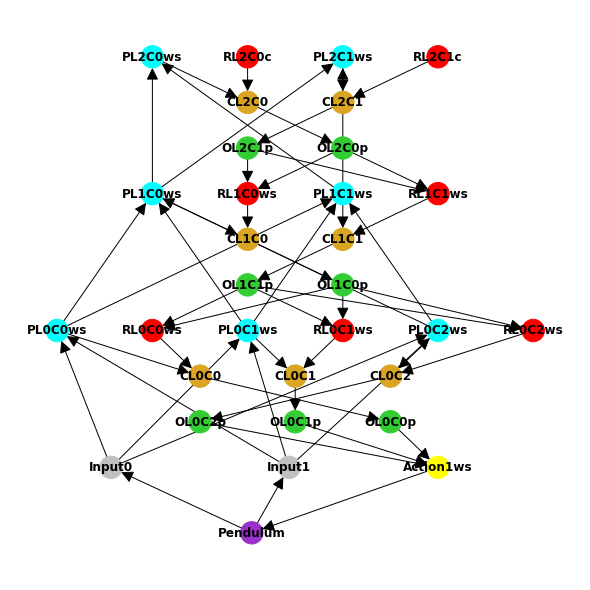

In [ ]:
pen = PendulumV0(name='Pendulum',render=True)
inputs=[2, 3]
config = {'level0': [[[0, 0, 1], [0, 0, 1]], [74.7727669099358, 37.42447782017047, 70.45900090605967], [[1, 0, 1]]], 'level1': [[[1, 0, 1], [1, 1, 1]], [0.028281504070566288, 0.29618653732851286], [[-49.05302284318027, 46.949638698585005], [-96.63198831250754, -29.78373183094591], [-3.8249493797145107, -60.95121501461629]]], 'level2': [[[1, 0], [0, 1]], [0.633350421196448, 0.5607290603484817], [[41.217164164869104, -76.70635343790484], [83.21744682425535, -96.9311066757899]], [1, 2]], 'parameters': {}}
for key in config.keys():
    print(key, config[key])
pa = ProportionalArchitecture(config=config, env=pen, input_indexes=inputs)
pa()
hpct = pa.get_hierarchy()
hpct.draw(move={'Pendulum': [-0.2, -0.3],'Input0': [-0.3, 0], 'Input1': [0.3, 0]})

level0 [[[0], [0]], [60.92750637861888], [[1]]]
level1 [[[1], [1]], [0.8221926728404025, 0.5936199577845901], [[2.941087338758976, -68.59700733589955]], [1, 2]]
parameters {}


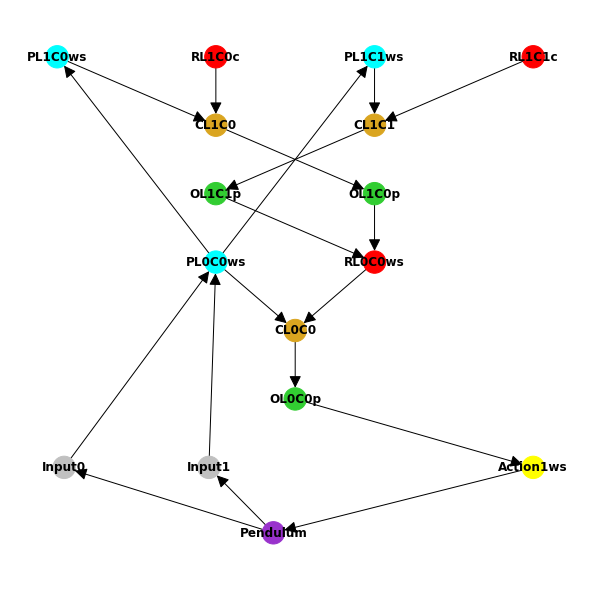

In [ ]:
pen = PendulumV0(name='Pendulum',render=True)
inputs=[2, 3]
config = {'level0': [[[0], [0]], [60.92750637861888], [[1]]], 'level1': [[[1], [1]], [0.8221926728404025, 0.5936199577845901], [[2.941087338758976, -68.59700733589955]], [1, 2]], 'parameters': {}}
for key in config.keys():
    print(key, config[key])
pa = ProportionalArchitecture(config=config, env=pen, input_indexes=inputs)
pa()
hpct = pa.get_hierarchy()
hpct.draw(move={'Pendulum': [-0.2, -0.3],'Input0': [-0.3, 0], 'Input1': [0.3, 0]})

level0 [[[1]], [62.82423385532463], [[0]], [1]]
parameters {}


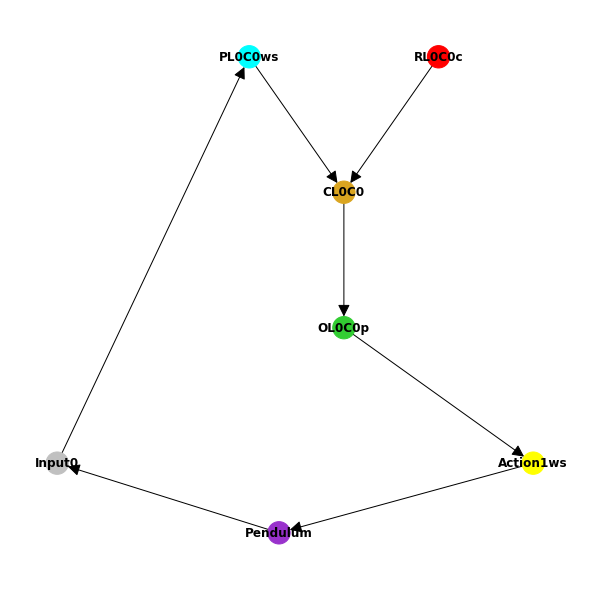

In [ ]:
pen = PendulumV0(name='Pendulum',render=True)
inputs=[2]
config = {'level0': [[[1]], [62.82423385532463], [[0]], [1]], 'parameters': {}}
for key in config.keys():
    print(key, config[key])
    
pa = ProportionalArchitecture(config=config, env=pen, input_indexes=inputs)
pa()
hpct = pa.get_hierarchy()
hpct.draw(move={'Pendulum': [-0.2, -0.3],'Input0': [-0.3, 0]})

In [ ]:
notebook2script()

Converted 00_examples.ipynb.
Converted 01_putils.ipynb.
Converted 02_functions.ipynb.
Converted 03_nodes.ipynb.
Converted 04_hierarchy.ipynb.
Converted 05_environments.ipynb.
Converted 06_structure.ipynb.
Converted 07_errors.ipynb.
Converted 08_architectures.ipynb.
Converted index.ipynb.
